# 🎂 Animal Breed Classification notebook 🎂

## TO DO:

> Multiclass Image Classification problem.

> Classification of Dogs and cats based on their breeds.

## Data:
> Dataset Given

* Dockship link:
https://dockship.io/challenges/5fdcba715f392d4d66289d43/animal-breed-classification-ai-challenge/overview

## Evaluate:

* Judgement: F1 Accuracy Score

## Features:
File descriptions
* train.zip - the training set, you are provided the breed for these dogs and cats
* test.zip - the test set, you must predict the probability of each breed for each image
* sample_submission.csv - a sample submission file in the correct format

## 🎇Imports

In [1]:
# Essentials
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from IPython.display import Image
import os
import datetime

In [2]:
# Import tensorflow and check GPU status
import tensorflow as tf
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())
print(tf.test.gpu_device_name())
print("check gpu:",tf.test.is_gpu_available())
import tensorflow_hub as hub
print("tf version:", tf.__version__)
print("hub version:", hub.__version__)
print("check gpu:",tf.config.experimental.list_physical_devices('GPU'))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10308718709749915479
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3065459508
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6640108688511593228
physical_device_desc: "device: 0, name: GeForce GTX 1650 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5"
]
/device:GPU:0
check gpu: True
tf version: 2.0.0
hub version: 0.8.0
check gpu: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 🎈Data Preparation

Before covert the data to Tensors, we need to:
1. Setup the labels from the training data set
2. Map the images to the correct labels
3. List the unique breeds

In [3]:
# Setup the labels
data_to_load = []
for breed in os.listdir("train"):
    for filepath in os.listdir("train/"+breed):
        data_to_load.append((filepath,breed,breed+"/"+filepath))

In [ ]:
data_to_load

In [4]:
# Map the images to the labels in DF
labels_df = pd.DataFrame(data_to_load, columns=['id', 'breed', 'filepath'])

In [5]:
labels_df.head(2)

,id,breed,filepath
0,1.jpg,abyssinian,abyssinian/1.jpg
1,10.jpg,abyssinian,abyssinian/10.jpg


In [6]:
# List the unique breed
unique_breeds = labels_df.breed.unique()

In [7]:
len(unique_breeds)

37

<AxesSubplot:>

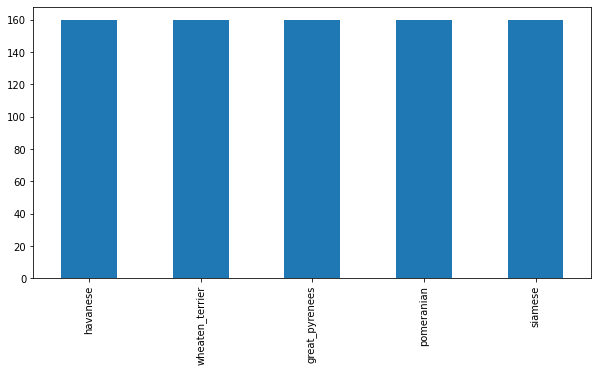

In [8]:
labels_df.breed.value_counts()[0:5].plot.bar(figsize=(10,5))

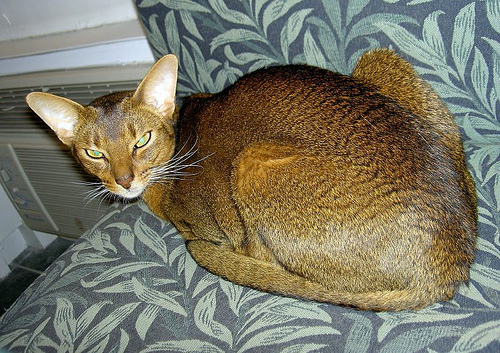

In [9]:
Image('TRAIN/'+labels_df.filepath[1])

In [33]:
# Now lets shuffle the dataFrame
shuffled_df = labels_df.sample(frac=1, random_state=42)
shuffled_df.reset_index(drop=True,inplace=True)
shuffled_df.head(3)

,id,breed,filepath
0,151.jpg,samoyed,samoyed/151.jpg
1,24.jpg,birman,birman/24.jpg
2,34.jpg,birman,birman/34.jpg


In [35]:
# get filenames using ids from label_csv
filenames = ['TRAIN/'+fname for fname in shuffled_df["filepath"]]

filenames[:10]

['TRAIN/samoyed/151.jpg',
 'TRAIN/birman/24.jpg',
 'TRAIN/birman/34.jpg',
 'TRAIN/miniature_pinscher/25.jpg',
 'TRAIN/russian_blue/112.jpg',
 'TRAIN/egyptian_mau/93.jpg',
 'TRAIN/bengal/71.jpg',
 'TRAIN/saint_bernard/56.jpg',
 'TRAIN/birman/37.jpg',
 'TRAIN/persian/14.jpg']

In [36]:
# Check if the total filenames amount is correct
total=0
for breed in shuffled_df.breed.unique():
    total+=len(os.listdir('TRAIN/'+breed))
    
if total == len(filenames):
    print("Count matches! All files are there.")
else:
    print("Count mismatch!")

Count matches! All files are there.


In [37]:
labels = shuffled_df.breed.to_numpy()

In [38]:
# Check the count of labels to that of the filenames
if len(labels)==len(filenames):
    print("Count matches! All labels are there.")
else:
    print("Count mismatch!")

Count matches! All labels are there.


In [39]:
# Turn every label into boolean array
boolean_labels = [label == unique_breeds for label in labels]

In [41]:
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False,  True, False, False, False, False, False, False,
        False]),
 array([False, False, False, False, False, False,  True, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False])]

In [42]:
# Creating our own validation set
X = filenames
y = boolean_labels

In [43]:
# Set number of imgs for exprimenting
NUM_IMAGES = 1000

In [44]:
# lets split data into train and validation

X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES], y[:NUM_IMAGES], test_size=0.2, random_state=42)

In [45]:
len(X_train), len(X_val),len(y_train),len(y_val)

(800, 200, 800, 200)

## 🎊Preprocessing

This is the part where we will convert the images to tensors.

### 🎭Turn imgs and labels to tensors

1. Take img filepaths
2. Use Tensorflow to read & save to variable
3. Turn images to tensors
4. Normalise the images
5. Resize img to shape
6. Return modified image

In [46]:
IMG_SIZE = 224
def process_image(image_path):
    '''
    Takes an image file path and turns the image into a Tensor
    '''
    image = tf.io.read_file(image_path)
    # change to tensors
    image = tf.image.decode_jpeg(image, channels=3)
    # Normalise image (convert values from 0-255 to 0-1)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size=[IMG_SIZE,IMG_SIZE])
    
    return image

In [47]:
# Turning data into Batches
BATCH_SIZE = 32

In [48]:
# Tensorflow requires a Tensor Tuple which is ('image','label')
def get_image_label(image_path, label):
    '''
    Takes iamge_path, label to process the image and return image and label
    '''
    image = process_image(image_path)
    
    return image,label

In [49]:
process_image(X[3])

<tf.Tensor: id=10, shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.07737127, 0.08672   , 0.06410096],
        [0.06661321, 0.08515282, 0.06714968],
        [0.05011286, 0.05764087, 0.03803303],
        ...,
        [0.72111344, 0.72144204, 0.6945432 ],
        [0.7219359 , 0.7179794 , 0.70152277],
        [0.68478984, 0.68086827, 0.665182  ]],

       [[0.09855255, 0.09816147, 0.08550952],
        [0.07202506, 0.0736357 , 0.06498725],
        [0.042039  , 0.0493166 , 0.03045999],
        ...,
        [0.7008382 , 0.71253824, 0.6699018 ],
        [0.6781348 , 0.68205637, 0.65852696],
        [0.6694205 , 0.67334205, 0.64981264]],

       [[0.08827563, 0.08975434, 0.07740784],
        [0.06706245, 0.06706245, 0.06706245],
        [0.05927591, 0.06704902, 0.05531932],
        ...,
        [0.68473506, 0.68872666, 0.65732473],
        [0.6841791 , 0.66583717, 0.64167744],
        [0.6854452 , 0.68695086, 0.6555783 ]],

       ...,

       [[0.35160398, 0.33869314, 0.36271104],
      

In [50]:
get_image_label(X[1],y[1])

(<tf.Tensor: id=21, shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.723747  , 0.67847764, 0.60175073],
         [0.7267745 , 0.6782101 , 0.59645236],
         [0.7292067 , 0.6820941 , 0.5913216 ],
         ...,
         [0.6758754 , 0.61313033, 0.48371857],
         [0.67209387, 0.6093488 , 0.47993702],
         [0.67810875, 0.6129827 , 0.49071383]],
 
        [[0.73878556, 0.6995699 , 0.594878  ],
         [0.74293095, 0.6958721 , 0.5948892 ],
         [0.7513731 , 0.70431423, 0.60235345],
         ...,
         [0.68565804, 0.62291294, 0.4935012 ],
         [0.67590934, 0.61316425, 0.48375246],
         [0.67474365, 0.6116372 , 0.4833096 ]],
 
        [[0.7358919 , 0.6966762 , 0.5951731 ],
         [0.7422632 , 0.69572204, 0.6007153 ],
         [0.74049747, 0.6940464 , 0.5996024 ],
         ...,
         [0.68221295, 0.6194566 , 0.4900786 ],
         [0.67546904, 0.6126677 , 0.48342472],
         [0.6785552 , 0.6158101 , 0.48639834]],
 
        ...,
 
        [[0.5924346 , 0.5

In [51]:
def create_data_batches(X, y=None, 
                        batchsize=BATCH_SIZE,
                        valid_data=False,
                        test_data=False):
    '''
    Creates batches of data out of image X and labels y pairs
    Shuffle the data if its training data but not when validation data
    Also accepts test data as input (no labels)
    '''
    # If data is test dataset, we dont have labels
    if test_data:
        print("Creating test_data batches!")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
        data_batch = data.map(process_image).batch(BATCH_SIZE)
        
        return data_batch
    # If data is valid dataset, we dont have to shuffle it
    elif valid_data:
        print("Creating valid_data batches!")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                                   tf.constant(y)))
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
        
        return data_batch
    else:
        print("Creating train_data batches!")
        # Create the dataset
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                                   tf.constant(y)))
        # Shuffle the dataset
        data = data.shuffle(buffer_size=len(X))
        # Preprocessing (Send filepath and label and get back the processed Tensor Image and label tuple)
        data = data.map(get_image_label)
        data_batch = data.batch(BATCH_SIZE)
        
        return data_batch

In [52]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val,
                               valid_data=True)

Creating train_data batches!
Creating valid_data batches!


In [53]:
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 37), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 37), dtype=tf.bool, name=None)))

In [54]:
len(unique_breeds)

37

In [58]:
# Lets Visualise the data batches
def show_25_images(images, labels):
    plt.figure(figsize=(15,15))
    for i in range(25):
        ax = plt.subplot(5, 5, i+1)
        plt.imshow(images[i])
        plt.title(unique_breeds[labels[i].numpy().argmax()])
        plt.axis("off")

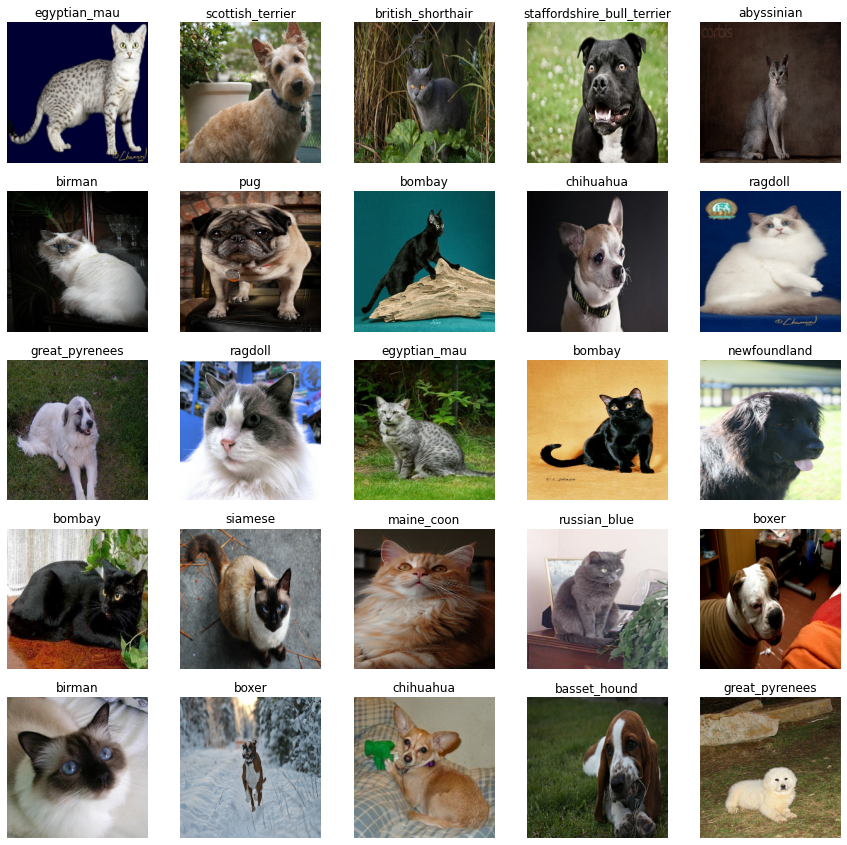

In [62]:
# Visualise the training data
iterator = iter(train_data)
train_images, train_labels = iterator.get_next()
show_25_images(train_images, train_labels)

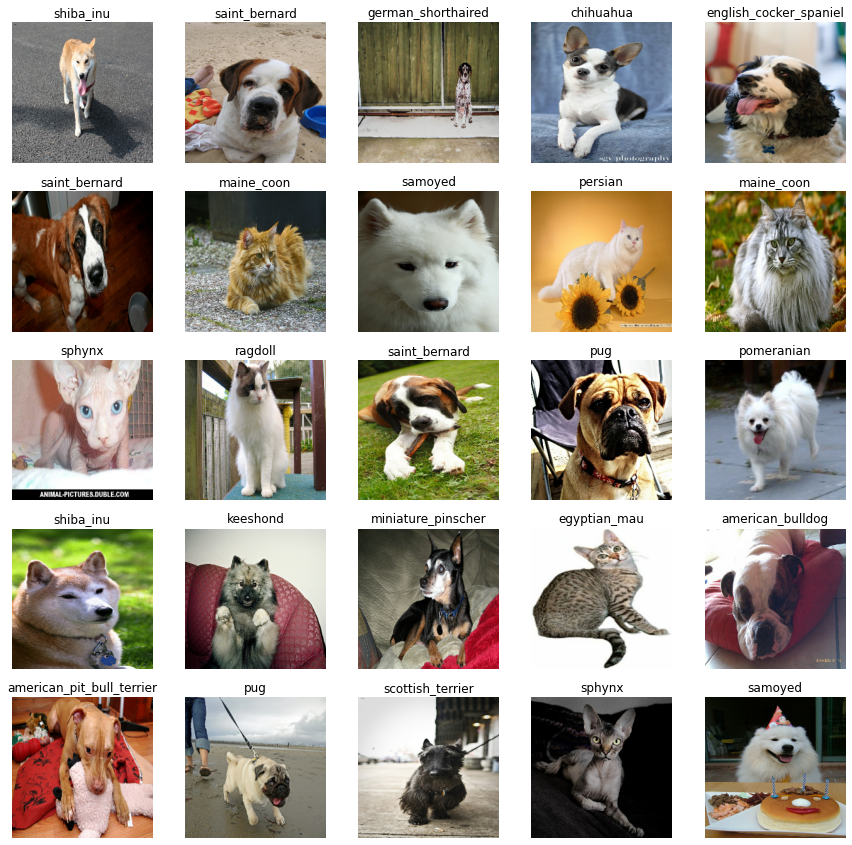

In [65]:
# Visualise the validation data
iterator_val = iter(val_data)
val_images, val_labels = iterator_val.get_next()
show_25_images(val_images, val_labels)

## 🎨 Building a model

Let's start working on the model now that we have the preprocessing completed.

Things to needed before building a model:

* The Input Shape
* The Output Shape
* The URL of the model
* Transfer Learning model URL from Tensorflow HUB

In [66]:
# Setup Input shape of the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3]

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow HUB
MODEL_URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"

🎉🎊We have the inputs, outputs and model ready🎉🎊 

Lets put them together into a Keras deep learning model!

Knowing this, lets create a funtion:

* Takes input shape, output shape and model we have chosen as parameter.
* Defines the model in a Keras model in sequential fashion.
* Compiles the model.
* Builds the model.
* Returns the model.

In [67]:
def create_model(input_shape=INPUT_SHAPE,
                 output_shape=OUTPUT_SHAPE,
                 model_url=MODEL_URL):
    '''
    Create a sequential model, compiles it and lastly builds the whole thing.
    '''
    print('Building model wiht: ', model_url)
    
    # Setup the model layers
    model = tf.keras.Sequential([
        hub.KerasLayer(model_url),
        tf.keras.layers.Dense(units=output_shape,
                              activation="softmax")
    ])
    
    # Compile the model
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"]
    )
    
    # Build the model
    model.build(input_shape)
    
    return model

In [68]:
model = create_model()

Building model wiht:  https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4


In [69]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  3540265   
_________________________________________________________________
dense (Dense)                multiple                  37074     
Total params: 3,577,339
Trainable params: 37,074
Non-trainable params: 3,540,265
_________________________________________________________________


## 🎏Creating call backs

Callbacks are helper functions to use during trainings to save progress, check progress or stop training early if model stops improving!

We will create two callbacks, one for TensorBoard which helps track model progress and another for early stopping if training is not improving.

## 🥽Tensorboard Callback

To Setup a TensorBoard callback, we need to do 3 things:
1. Load the tensorBoard notebook extension
2. Create a tensorboard callback which is able to sab logs to a dir and pass it to our models `fit()` functions.
3. Visualise model training logs wiht `%tensorboard` magic function.

In [70]:
# Load Tensorboad notebook extension
%load_ext tensorboard

In [71]:
# Create a function to build tensorboard callback
def create_tensorboard_callback():
    logdir = os.path.join('logs',
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    
    return tf.keras.callbacks.TensorBoard(logdir)

## 🎢Early Stopping callback

We need early stopping so that model does not start overfitting.

In [73]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

## 🎠Training a model (on subset of data)
Our first model on 1000 images

In [74]:
# Set the number of epochs
NUM_EPOCH=100

#### 🎍Function to train a model.

* Create a model using `create_model()`
* Setup a TensorBoard callback using `create_tensorboard_callback()
* Call the `fit()` function on model passing it train data, val data, no of epochs and the callbacks.
* return the model

In [75]:
# Build function to train the model
def train_model():
    '''
    Trains model and returns trained version.
    '''
    # create the model
    model = create_model()
    
    # Create tensorboard session
    tensorboard = create_tensorboard_callback()
    
    # Fit the model
    model.fit(x=train_data,
              epochs=NUM_EPOCH,
              validation_data=val_data,
              validation_freq=1,
              callbacks=[tensorboard, early_stopping])
    
    return model

In [76]:
model = train_model()

Building model wiht:  https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4
Epoch 1/100
      1/Unknown - 7s 7s/step - loss: 4.6706 - accuracy: 0.0312WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.175846). Check your callbacks.


25/25 [==============================] - 16s 631ms/step - loss: 2.7378 - accuracy: 0.3250 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
25/25 [==============================] - 3s 123ms/step - loss: 0.6424 - accuracy: 0.8587 - val_loss: 0.6290 - val_accuracy: 0.8350
Epoch 3/100
25/25 [==============================] - 3s 135ms/step - loss: 0.2572 - accuracy: 0.9525 - val_loss: 0.5046 - val_accuracy: 0.8400
Epoch 4/100
25/25 [==============================] - 3s 134ms/step - loss: 0.1520 - accuracy: 0.9837 - val_loss: 0.4719 - val_accuracy: 0.8550
Epoch 5/100
25/25 [==============================] - 4s 150ms/step - loss: 0.1058 - accuracy: 0.9912 - val_loss: 0.4353 - val_accuracy: 0.8600
Epoch 6/100
25/25 [==============================] - 4s 142ms/step - loss: 0.0775 - accuracy: 0.9975 - val_loss: 0.4300 - val_accuracy: 0.8650
Epoch 7/100
25/25 [==============================] - 4s 164ms/step - loss: 0.0600 - accuracy: 0.9987 - val_loss: 0.4078 - val_accuracy: 0.8650
Ep

## Checking Tensorboard logs

Use `%tensorboard` to access logs and visualise its contents.

In [77]:
# http://localhost:6006/
%tensorboard --logdir logs

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 18996.

## Making and evaluating predictions using training model

In [78]:
# Make predictions on the validation data
predictions = model.predict(val_data, verbose=1)

7/7 [==============================] - 1s 150ms/step


In [79]:
# Function to visualise the predictions
def get_pred_label(prediction_probs):
    '''
    Turns an array of prediction probabilities into a label.
    '''
    return unique_breeds[np.argmax(prediction_probs)]

In [80]:
# Get a prdicted label based on an array of prediction probs
pred_label = get_pred_label(predictions[81])
pred_label

'beagle'

## Unbatch dataset to compare the predictions to validation labels

In [81]:
# create function to unbatch a batch dataset
def unbatchify(batch_data):
    images=[]
    labels=[]
    for image, label in iter(batch_data.unbatch()):
        images.append(image)
        labels.append(unique_breeds[np.argmax(label)])
    return images,labels

In [82]:
val_images, val_labels = unbatchify(val_data)

In [83]:
get_pred_label(val_labels[0]), get_pred_label(predictions[0])

('abyssinian', 'shiba_inu')

## Visualise the predctions

Create function which takes an array of prediction probs,
 an array of truth labels and array of images and integers.


In [84]:
def plot_pred(prediction_probs, labels, images, n=1):
    '''
    View the prediction, ground truth and image for sample n
    '''
    pred_prob, true_label, image = prediction_probs[n], labels[n], images[n]
    
    #Get pred label
    pred_label = get_pred_label(pred_prob)
    
    # PLot image
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    
    # Change the colors
    if pred_label == true_label:
        color="green"
    else:
        color="red"
    
    # Change plot titles
    plt.title("{} {:2.0f}% {}".format(pred_label,
                                      np.max(pred_prob)*100,
                                      true_label),color=color)
    

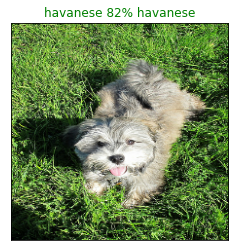

In [91]:
plot_pred(prediction_probs=predictions,
          labels=val_labels,
          images=val_images,n=69)

In [92]:
# Create function to predict the top 10 predictions
def plot_pred_conf(prediction_probs, labels, n=1):
    '''
    Plus the top 10 highest prediction confidences aloing with the truth label for sample data
    '''
    pred_prob, true_label = prediction_probs[n], labels[n]
    
    # Get the predicted label
    pred_label = get_pred_label(pred_prob)
    
    # Find top 10 prediction confidence indexes
    top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]    
    
    # Find the top 10 prediction confidence values
    top_10_pred_values = pred_prob[top_10_pred_indexes]
    
    # Find the top 10 prediction labels
    top_10_pred_labels = unique_breeds[top_10_pred_indexes]
    
    # Setup plot
    top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                       top_10_pred_values,
                       color="grey")
    plt.xticks(np.arange(len(top_10_pred_labels)),
               labels=top_10_pred_labels,
               rotation="vertical")
    
    # Change the color of true label
    if np.isin(true_label, top_10_pred_labels):
        top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
    else:
        pass  

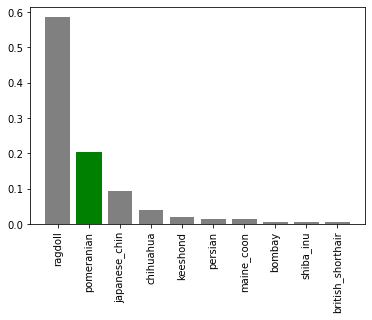

In [96]:
plot_pred_conf(prediction_probs=predictions,
               labels=val_labels,
               n=)

## Visualise more data

create multiple subplots with images and confidence.

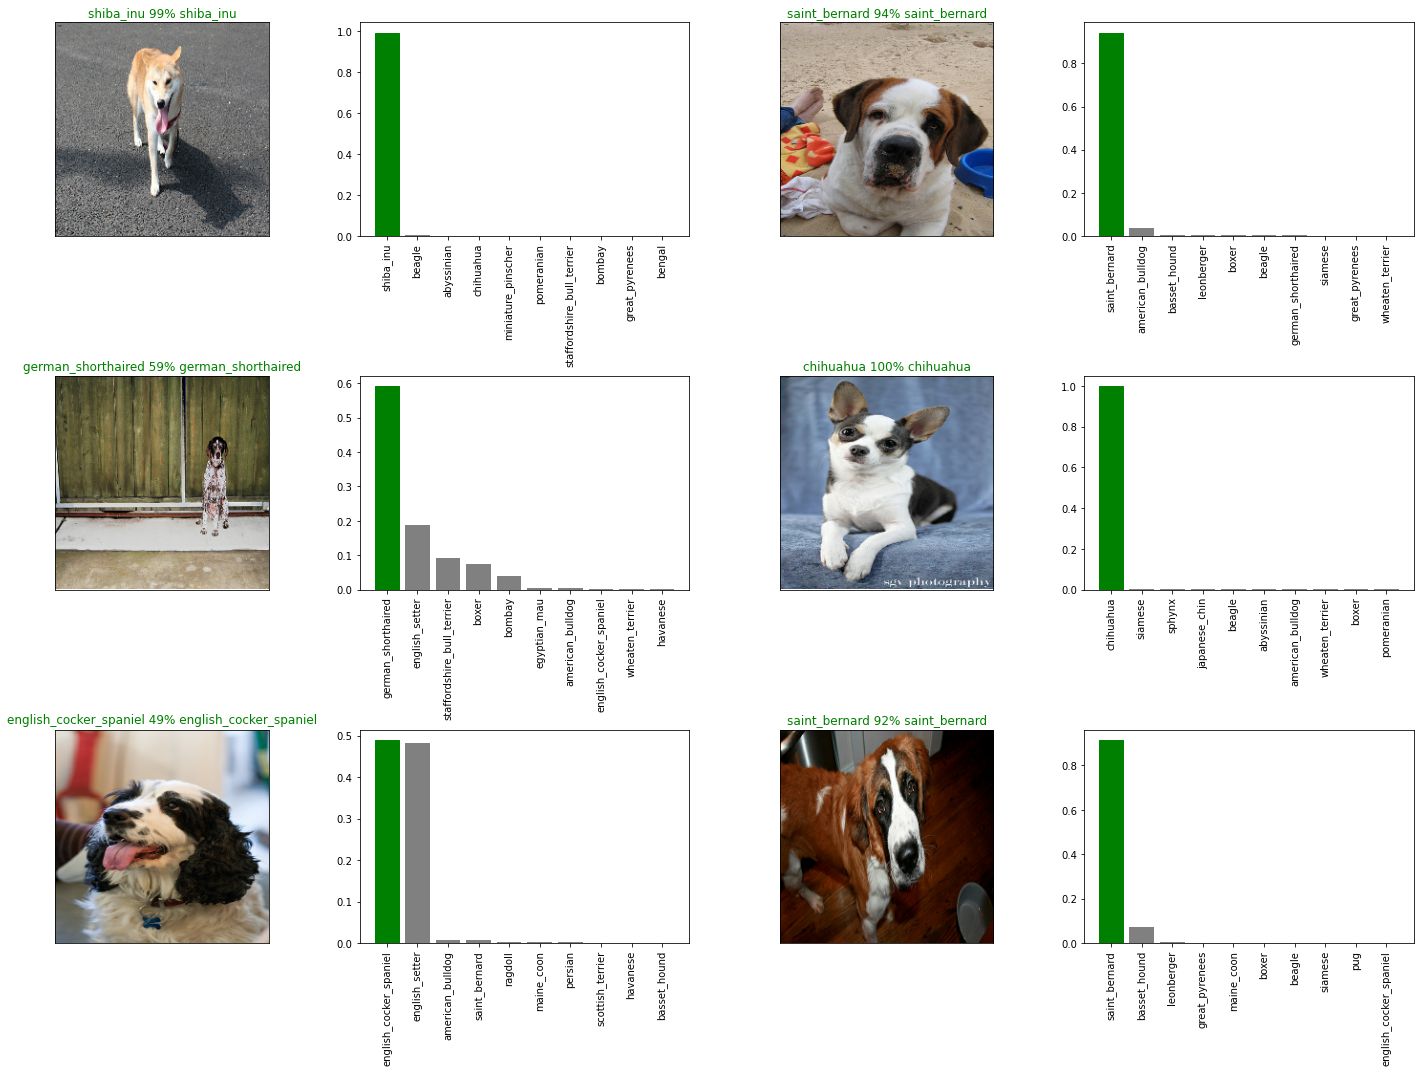

In [98]:
# Few predictions and their different values
i_multiplier = 0
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_pred(prediction_probs=predictions,
              labels=val_labels,
              images=val_images,
              n=i+i_multiplier)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_pred_conf(prediction_probs=predictions,
                   labels=val_labels,
                   n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

## Saving the model

In [99]:
# Create function to save model
def save_model(model, suffix=None):
    '''
    Save a given model with a suffix
    '''
    # Create model dir pathname with current time
    modeldir=os.path.join("models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    model_path=modeldir + "-" + suffix + ".h5"
    print(f"Saving model to path: {model_path}...")
    model.save(model_path)
#     return model_path

# Create function to load model
def load_model(model_path):
    '''Load model'''
    print(f"Loading saved model from: {model_path}")
    model = tf.keras.models.load_model(model_path,
                                      custom_objects={"KerasLayer":hub.KerasLayer})
    return model 

In [100]:
# Save our model trained on 1000images
save_model(model, suffix="1000-images-mobilenetv2-Adam")

Saving model to path: models\20210508-140025-1000-images-mobilenetv2-Adam.h5...


In [102]:
loaded_1000_image_model = load_model("models/20210508-140025-1000-images-mobilenetv2-Adam.h5")

Loading saved model from: models/20210508-140025-1000-images-mobilenetv2-Adam.h5


In [103]:
model.evaluate(val_data), loaded_1000_image_model.evaluate(val_data)

7/7 [==============================] - 1s 166ms/step - loss: 0.3910 - accuracy: 0.86500s - loss: 0.3595 - accuracy: 0.


([0.3910329895360129, 0.865], [0.3910329895360129, 0.865])

## 🎪Traning the model on full dataset

In [104]:
len(X), len(y)

(5890, 5890)

In [105]:
# Create a data batch with full data
full_data = create_data_batches(X, y)

Creating train_data batches!


In [106]:
# Create a model for full model
full_model = create_model()

Building model wiht:  https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4


In [107]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
# No validation set when training on all data, so we cant monitor accuray
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

In [108]:
# Fit the full model
full_model.fit(x=full_data,
               epochs=NUM_EPOCH,
               callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
      1/Unknown - 4s 4s/step - loss: 4.4102 - accuracy: 0.0312WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.287560). Check your callbacks.


185/185 [==============================] - 58s 311ms/step - loss: 0.7980 - accuracy: 0.7740
Epoch 2/100
185/185 [==============================] - 18s 95ms/step - loss: 0.2165 - accuracy: 0.9304
Epoch 3/100
185/185 [==============================] - 18s 98ms/step - loss: 0.1335 - accuracy: 0.96261s - los - ETA: 0s - loss: 0.1329 - accuracy
Epoch 4/100
185/185 [==============================] - 18s 95ms/step - loss: 0.0925 - accuracy: 0.9786
Epoch 5/100
185/185 [==============================] - 19s 100ms/step - loss: 0.0676 - accuracy: 0.9852
Epoch 6/100
185/185 [==============================] - 19s 100ms/step - loss: 0.0508 - accuracy: 0.9913s - loss: 0.0492 - 
Epoch 7/100
185/185 [==============================] - 19s 102ms/step - loss: 0.0406 - accuracy: 0.9949
Epoch 8/100
185/185 [==============================] - 19s 100ms/step - loss: 0.0327 - accuracy: 0.9956
Epoch 9/100
185/185 [==============================] - 19s 102ms/step - loss: 0.0310 - accuracy: 0.9971
Epoch 10/100
185

In [109]:
save_model(full_model, suffix="All-images-mobilenetv2-Adam")

Saving model to path: models\20210508-140819-All-images-mobilenetv2-Adam.h5...


## Making predictions on test dataset

In [110]:
# Load test image filesnames
test_filenames = ["test/"+fname for fname in os.listdir("test")]
test_filenames[:10]

['test/1.jpg',
 'test/10.jpg',
 'test/100.jpg',
 'test/1000.jpg',
 'test/1001.jpg',
 'test/1002.jpg',
 'test/1003.jpg',
 'test/1004.jpg',
 'test/1005.jpg',
 'test/1006.jpg']

In [111]:
# Convert the filename to data batches
test_data=create_data_batches(X=test_filenames, test_data=True)

Creating test_data batches!


In [112]:
test_data

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [113]:
# Call `predict()` on full model. This will take some time.
test_predictions = full_model.predict(test_data,
                                      verbose=1)

47/47 [==============================] - 8s 181ms/step


In [114]:
test_predictions.shape

(1500, 37)

In [115]:
test_predictions[:2]

array([[2.4390495e-10, 2.6448672e-03, 1.0180005e-02, 2.7092296e-06,
        3.9315791e-09, 7.2252152e-07, 4.2461966e-07, 3.1847250e-07,
        1.2051499e-04, 1.3490596e-07, 2.1485087e-09, 8.1966436e-06,
        1.0553604e-09, 2.8475488e-06, 6.7165115e-06, 1.6065528e-08,
        1.3952071e-07, 5.6500067e-09, 1.9881631e-10, 6.1426242e-09,
        2.9031563e-07, 8.2496328e-08, 3.2308569e-07, 1.0282663e-08,
        1.2611648e-10, 3.0457047e-03, 3.5065100e-09, 4.5258588e-07,
        4.4478866e-06, 9.7930517e-09, 9.4092904e-08, 1.6707818e-06,
        1.5195514e-08, 2.4262653e-07, 9.8397875e-01, 2.9878089e-07,
        3.5566941e-08],
       [1.1153684e-08, 2.1132030e-06, 1.4582031e-09, 3.8004078e-08,
        3.3120978e-10, 3.1367556e-08, 3.2025294e-08, 6.7297790e-08,
        3.2389566e-05, 1.2213672e-08, 1.7123498e-09, 1.2934842e-09,
        1.2158098e-08, 5.1061004e-09, 1.2011433e-08, 5.8509246e-09,
        5.9088273e-07, 6.9030222e-09, 3.1326108e-09, 1.4840028e-09,
        1.2073574e-10, 3

## Preparing test dataset predictions for Dockship

In [116]:
# Create a pandas DF with columns
preds_df = pd.DataFrame(columns=["Filename","Class"])

In [117]:
preds_df

,Filename,Class


In [120]:
# Append test image IDs to prediction DF
test_ids = [image for image in os.listdir("test")]

In [121]:
preds_df["Filename"] = test_ids

In [122]:
preds_df

,Filename,Class
0,1.jpg,NaN
1,10.jpg,NaN
2,100.jpg,NaN
3,1000.jpg,NaN
4,1001.jpg,NaN
...,...,...
1495,995.jpg,NaN
1496,996.jpg,NaN
1497,997.jpg,NaN
1498,998.jpg,NaN


In [125]:
# Get a prdicted label based on an array of prediction probs
pred_label = get_pred_label(test_predictions[0])
pred_label

'staffordshire_bull_terrier'

In [140]:
# Now lets get the predicted labels for the filenames
test=list(map(lambda x:get_pred_label(x),test_predictions))
preds_df.Class = test

In [142]:
preds_df.head(20)

,Filename,Class
0,1.jpg,staffordshire_bull_terrier
1,10.jpg,pug
2,100.jpg,chihuahua
3,1000.jpg,miniature_pinscher
4,1001.jpg,pomeranian
5,1002.jpg,samoyed
6,1003.jpg,bombay
7,1004.jpg,miniature_pinscher
8,1005.jpg,havanese
9,1006.jpg,american_pit_bull_terrier


In [143]:
# Save the DF to csv
preds_df.to_csv("full_model_preds1.csv", index=False)